In [ ]:
https://towardsdatascience.com/reinforcement-learning-with-tensorflow-agents-tutorial-4ac7fa858728

In [ ]:
#pip install tensorflow==2.2.0
!pip install tf-agents

     |████████████████████████████████| 1.1MB 5.2MB/s 


In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent

from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [ ]:
env = suite_gym.load('CartPole-v1')
env = tf_py_environment.TFPyEnvironment(env)

In [ ]:
q_net = q_network.QNetwork(env.observation_spec(), 
                           env.action_spec())

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

In [ ]:
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(env.time_step_spec(),
                           env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           td_errors_loss_fn= 
                                  common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0        
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return    
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [ ]:
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy, 5)
returns = [avg_return]

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                data_spec=agent.collect_data_spec,                                                                
                                batch_size=env.batch_size,                                                              
                                max_length=100000)


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)
    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [ ]:
collect_steps_per_iteration = 1
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                   sample_batch_size=batch_size, 
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)
num_iterations = 20000
env.reset()

for _ in range(batch_size):
    collect_step(env, agent.policy, replay_buffer)

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(env, agent.collect_policy, replay_buffer)    
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss    
    step = agent.train_step_counter.numpy()    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(env, agent.policy, 5)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 16.591285705566406
step = 400: loss = 12.585597038269043
step = 600: loss = 20.096038818359375
step = 800: loss = 11.211697578430176
step = 1000: loss = 66.51399230957031
step = 1000: Average Return = 43.0
step = 1200: loss = 144.00088500976562
step = 1400: loss = 307.5181884765625
step = 1600: loss = 245.3841552734375
step = 1800: loss = 653.9501342773438
step = 2000: loss = 288.7919616699219
step = 2000: Average Return = 150.8000030517578
step = 2200: loss = 803.0383911132812
step = 2400: loss = 188.69383239746094
step = 2600: loss = 384.85064697265625
step = 2800: loss = 204.84268188476562
step = 3000: loss = 193.45167541503906
step = 3000: Average Return = 105.80000305175781
step = 3200: loss = 183.96319580078125
step = 3400: loss = 160.9153289794922
step = 3600: loss = 839.531982421875
step = 3800: loss = 465.5520324707031
step = 4000: loss = 615.9669799804688
step = 4000: Average Return = 413.0
step = 4200: loss = 628.8997192382812
step = 4400: loss = 18019.046

Text(0.5, 0, 'Iterations')

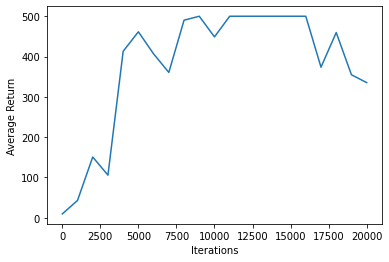

In [ ]:
iterations = range(0, num_iterations + 1, 1000)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [ ]:
http://neuro-educator.com/rl1/

In [ ]:
# [0]ライブラリのインポート
import gym  #倒立振子(cartpole)の実行環境
from gym import wrappers  #gymの画像保存
import numpy as np
import time
 

In [ ]:

 
# [1]Q関数を離散化して定義する関数　------------
# 観測した状態を離散値にデジタル変換する
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]
 
# 各値を離散値に変換
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, num_dizitized)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, num_dizitized)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, num_dizitized)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, num_dizitized))
    ]
    return sum([x * (num_dizitized**i) for i, x in enumerate(digitized)])

In [ ]:
# [2]行動a(t)を求める関数 -------------------------------------
def get_action(next_state, episode):
           #徐々に最適行動のみをとる、ε-greedy法
    epsilon = 0.5 * (1 / (episode + 1))
    if epsilon <= np.random.uniform(0, 1):
        next_action = np.argmax(q_table[next_state])
    else:
        next_action = np.random.choice([0, 1])
    return next_action

In [ ]:

 
 
# [3]Qテーブルを更新する関数 -------------------------------------
def update_Qtable(q_table, state, action, reward, next_state):
    gamma = 0.99
    alpha = 0.5
    next_Max_Q=max(q_table[next_state][0],q_table[next_state][1] )
    q_table[state, action] = (1 - alpha) * q_table[state, action] +\
            alpha * (reward + gamma * next_Max_Q)
   
    return q_table
 

In [ ]:


# [4]. メイン関数開始 パラメータ設定--------------------------------------------------------
env = gym.make('CartPole-v0')
max_number_of_steps = 200  #1試行のstep数
num_consecutive_iterations = 100  #学習完了評価に使用する平均試行回数
num_episodes = 2000  #総試行回数
goal_average_reward = 195  #この報酬を超えると学習終了（中心への制御なし）
# 状態を6分割^（4変数）にデジタル変換してQ関数（表）を作成
num_dizitized = 6  #分割数
q_table = np.random.uniform(
    low=-1, high=1, size=(num_dizitized**4, env.action_space.n))
 
total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納
final_x = np.zeros((num_episodes, 1))  #学習後、各試行のt=200でのｘの位置を格納
islearned = 0  #学習が終わったフラグ
isrender = 0  #描画フラグ
 

In [ ]:

 
 
 
# [5] メインルーチン--------------------------------------------------
for episode in range(num_episodes):  #試行数分繰り返す
    # 環境の初期化
    observation = env.reset()
    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    episode_reward = 0
 
    for t in range(max_number_of_steps):  #1試行のループ
        if islearned == 1:  #学習終了したらcartPoleを描画する
            env.render()
            time.sleep(0.1)
            print (observation[0])  #カートのx位置を出力
 
        # 行動a_tの実行により、s_{t+1}, r_{t}などを計算する
        observation, reward, done, info = env.step(action)
 
        # 報酬を設定し与える
        if done:
            if t < 195:
                reward = -200  #こけたら罰則
            else:
                reward = 1  #立ったまま終了時は罰則はなし
        else:
            reward = 1  #各ステップで立ってたら報酬追加
 
        episode_reward += reward  #報酬を追加
 
        # 離散状態s_{t+1}を求め、Q関数を更新する
        next_state = digitize_state(observation)  #t+1での観測状態を、離散値に変換
        q_table = update_Qtable(q_table, state, action, reward, next_state)
        
        #  次の行動a_{t+1}を求める 
        action = get_action(next_state, episode)    # a_{t+1} 
        
        state = next_state
        
        #終了時の処理
        if done:
            print('%d Episode finished after %f time steps / mean %f' %
                  (episode, t + 1, total_reward_vec.mean()))
            total_reward_vec = np.hstack((total_reward_vec[1:],
                                          episode_reward))  #報酬を記録
            if islearned == 1:  #学習終わってたら最終のx座標を格納
                final_x[episode, 0] = observation[0]
            break
 
    if (total_reward_vec.mean() >=
            goal_average_reward):  # 直近の100エピソードが規定報酬以上であれば成功
        print('Episode %d train agent successfuly!' % episode)
        islearned = 1
        #np.savetxt('learned_Q_table.csv',q_table, delimiter=",") #Qtableの保存する場合
        if isrender == 0:
            #env = wrappers.Monitor(env, './movie/cartpole-experiment-1') #動画保存する場合
            isrender = 1
    #10エピソードだけでどんな挙動になるのか見たかったら、以下のコメントを外す
    #if episode>10:
    #    if isrender == 0:
    #        env = wrappers.Monitor(env, './movie/cartpole-experiment-1') #動画保存する場合
    #        isrender = 1
    #    islearned=1;
 
if islearned:
    np.savetxt('final_x.csv', final_x, delimiter=",")

0 Episode finished after 16.000000 time steps / mean 0.000000
1 Episode finished after 17.000000 time steps / mean -1.850000
2 Episode finished after 55.000000 time steps / mean -3.690000
3 Episode finished after 38.000000 time steps / mean -5.150000
4 Episode finished after 11.000000 time steps / mean -6.780000
5 Episode finished after 42.000000 time steps / mean -8.680000
6 Episode finished after 29.000000 time steps / mean -10.270000
7 Episode finished after 10.000000 time steps / mean -11.990000
8 Episode finished after 33.000000 time steps / mean -13.900000
9 Episode finished after 9.000000 time steps / mean -15.580000
10 Episode finished after 25.000000 time steps / mean -17.500000
11 Episode finished after 11.000000 time steps / mean -19.260000
12 Episode finished after 15.000000 time steps / mean -21.160000
13 Episode finished after 10.000000 time steps / mean -23.020000
14 Episode finished after 27.000000 time steps / mean -24.930000
15 Episode finished after 11.000000 time st

NameError: ignored

In [ ]:
https://elix-tech.github.io/ja/2016/06/29/dqn-ja.html

In [ ]:
http://neuro-educator.com/rl2/

In [ ]:
# [0]必要なライブラリのインポート
import gym  # 倒立振子(cartpole)の実行環境
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import plot_model
from collections import deque
from gym import wrappers  # gymの画像保存
from keras import backend as K
 
# [1]損失関数の定義
# 損失関数に関数を使用します
def huberloss(y_true, y_pred):
    return K.mean(K.minimum(0.5*K.square(y_pred-y_true), K.abs(y_pred-y_true)-0.5), axis=1)
 
 
# [2]Q関数をディープラーニングのネットワークをクラスとして定義
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10):
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.optimizer = Adam(lr=learning_rate)  # 誤差を減らす学習方法はAdam
        # self.model.compile(loss='mse', optimizer=self.optimizer)
        self.model.compile(loss=huberloss, optimizer=self.optimizer)
 
    # 重みの学習
    def replay(self, memory, batch_size, gamma, targetQN):
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))
        mini_batch = memory.sample(batch_size)
 
        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(mini_batch):
            inputs[i:i + 1] = state_b
            target = reward_b
 
            if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                # 価値計算（DDQNにも対応できるように、行動決定のQネットワークと価値観数のQネットワークは分離）
                retmainQs = self.model.predict(next_state_b)[0]
                next_action = np.argmax(retmainQs)  # 最大の報酬を返す行動を選択する
                target = reward_b + gamma * targetQN.model.predict(next_state_b)[0][next_action]
                
            targets[i] = self.model.predict(state_b)    # Qネットワークの出力
            targets[i][action_b] = target               # 教師信号
            self.model.fit(inputs, targets, epochs=1, verbose=0)  # epochsは訓練データの反復回数、verbose=0は表示なしの設定
 
 
# [3]Experience ReplayとFixed Target Q-Networkを実現するメモリクラス
class Memory:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
 
    def add(self, experience):
        self.buffer.append(experience)
 
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]
 
    def len(self):
        return len(self.buffer)
 
 
# [4]カートの状態に応じて、行動を決定するクラス
class Actor:
    def get_action(self, state, episode, targetQN):   # [C]ｔ＋１での行動を返す
        # 徐々に最適行動のみをとる、ε-greedy法
        epsilon = 0.001 + 0.9 / (1.0+episode)
 
        if epsilon <= np.random.uniform(0, 1):
            retTargetQs = targetQN.model.predict(state)[0]
            action = np.argmax(retTargetQs)  # 最大の報酬を返す行動を選択する
 
        else:
            action = np.random.choice([0, 1])  # ランダムに行動する
 
        return action
 
 
# [5] メイン関数開始----------------------------------------------------
# [5.1] 初期設定--------------------------------------------------------
DQN_MODE = 1    # 1がDQN、0がDDQNです
LENDER_MODE = 1 # 0は学習後も描画なし、1は学習終了後に描画する
 
env = gym.make('CartPole-v0')
num_episodes = 299  # 総試行回数
max_number_of_steps = 200  # 1試行のstep数
goal_average_reward = 195  # この報酬を超えると学習終了
num_consecutive_iterations = 10  # 学習完了評価の平均計算を行う試行回数
total_reward_vec = np.zeros(num_consecutive_iterations)  # 各試行の報酬を格納
gamma = 0.99    # 割引係数
islearned = 0  # 学習が終わったフラグ
isrender = 0  # 描画フラグ
# ---
hidden_size = 16               # Q-networkの隠れ層のニューロンの数
learning_rate = 0.00001         # Q-networkの学習係数
memory_size = 10000            # バッファーメモリの大きさ
batch_size = 32                # Q-networkを更新するバッチの大記載
 
# [5.2]Qネットワークとメモリ、Actorの生成--------------------------------------------------------
mainQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate)     # メインのQネットワーク
targetQN = QNetwork(hidden_size=hidden_size, learning_rate=learning_rate)   # 価値を計算するQネットワーク
# plot_model(mainQN.model, to_file='Qnetwork.png', show_shapes=True)        # Qネットワークの可視化
memory = Memory(max_size=memory_size)
actor = Actor()
 
# [5.3]メインルーチン--------------------------------------------------------
for episode in range(num_episodes):  # 試行数分繰り返す
    env.reset()  # cartPoleの環境初期化
    state, reward, done, _ = env.step(env.action_space.sample())  # 1step目は適当な行動をとる
    state = np.reshape(state, [1, 4])   # list型のstateを、1行4列の行列に変換
    episode_reward = 0
 
    targetQN = mainQN   # 行動決定と価値計算のQネットワークをおなじにする
 
    for t in range(max_number_of_steps + 1):  # 1試行のループ
        if (islearned == 1) and LENDER_MODE:  # 学習終了したらcartPoleを描画する
            env.render()
            time.sleep(0.1)
            print(state[0, 0])  # カートのx位置を出力するならコメントはずす
 
        action = actor.get_action(state, episode, mainQN)   # 時刻tでの行動を決定する
        next_state, reward, done, info = env.step(action)   # 行動a_tの実行による、s_{t+1}, _R{t}を計算する
        next_state = np.reshape(next_state, [1, 4])     # list型のstateを、1行4列の行列に変換
 
        # 報酬を設定し、与える
        if done:
            next_state = np.zeros(state.shape)  # 次の状態s_{t+1}はない
            if t < 195:
                reward = -1  # 報酬クリッピング、報酬は1, 0, -1に固定
            else:
                reward = 1  # 立ったまま195step超えて終了時は報酬
        else:
            reward = 0  # 各ステップで立ってたら報酬追加（はじめからrewardに1が入っているが、明示的に表す）
 
        episode_reward += 1 # reward  # 合計報酬を更新
 
        memory.add((state, action, reward, next_state))     # メモリの更新する
        state = next_state  # 状態更新
 
 
        # Qネットワークの重みを学習・更新する replay
        if (memory.len() > batch_size) and not islearned:
            mainQN.replay(memory, batch_size, gamma, targetQN)
 
        if DQN_MODE:
            targetQN = mainQN  # 行動決定と価値計算のQネットワークをおなじにする
 
        # 1施行終了時の処理
        if done:
            total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward))  # 報酬を記録
            print('%d Episode finished after %f time steps / mean %f' % (episode, t + 1, total_reward_vec.mean()))
            break
 
    # 複数施行の平均報酬で終了を判断
    if total_reward_vec.mean() >= goal_average_reward:
        print('Episode %d train agent successfuly!' % episode)
        islearned = 1
        if isrender == 0:   # 学習済みフラグを更新
            isrender = 1
 
            # env = wrappers.Monitor(env, './movie/cartpoleDDQN')  # 動画保存する場合
            # 10エピソードだけでどんな挙動になるのか見たかったら、以下のコメントを外す
            # if episode>10:
            #    if isrender == 0:
            #        env = wrappers.Monitor(env, './movie/cartpole-experiment-1') #動画保存する場合
            #        isrender = 1
            #    islearned=1;

In [ ]:
https://ailog.site/2019/10/25/torch7/

In [ ]:
https://deepage.net/features/numpy-rl.html